In [5]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import datetime
from dateutil.relativedelta import relativedelta
import calendar
from datetime import date
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_curve, auc, precision_recall_curve
from sklearn import metrics
from scipy import stats
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from scipy.stats import zscore
import pickle
class Kiddi():
    def __init__(self, IS_RAW_PATH, IWP_PATH, IWES_PATH, CENSUS_PATH):
        self.df = pd.read_excel(IS_RAW_PATH)
        self.df_iwp = pd.read_excel(IWP_PATH)[['idd','peritonitisdate']]
        self.df_iwes = pd.read_excel(IWES_PATH)[['idd','exitsitedate']]
        self.df_census = pd.read_excel(CENSUS_PATH)[['idd','PatientAge','male','Diabetes','PDVintage','MQexist']]
        # self.df = colab_df
        # self.df_iwp = colab_df_iwp[['idd','peritonitisdate']]
        # self.df_iwes = colab_df_iwes[['idd','exitsitedate']]
        # self.df_census = colab_df_census[['idd','PatientAge','male','Diabetes','PDVintage','MQexist']]
        self.target_df = None
        self.population = None
        self.is_raw_partition = dict()
        self.st_data_dt = None
        self.end_data_dt = None
        self.is_raw_col = []
        self.all_data = None
        self.train = None
        self.validation = None
        self.test = None
        self.train_X = None
        self.train_y = None
        self.val_X = None
        self.val_y = None
        self.test_X = None
        self.test_y = None
        self.model = None
        self.final_score = None
        self.prep_data = None
        self.model_feature = None
        self.feature_columns = None
        
    def transform_is_raw(self):
        recentLabCol = ['qRecentLabDt1','qRecentLabDt2','qRecentLabDt3','qRecentLabDt4']
        # Change recent lab date to the end of month
        df = self.get_df()
        for index, col in enumerate(recentLabCol):
          df['ft_data_dt_'+str(index)] = pd.to_datetime(df[col], format="%Y%m")
        feature_list = ["qSodium1Val", "qSodium2Val", "qSodium3Val", "qSodium4Val", "qPotass1Val", "qPotass2Val", "qPotass3Val", 
"qPotass4Val", "qBicarb1Val", "qBicarb2Val", "qBicarb3Val", "qBicarb4Val", "qCreat1Val", "qCreat2Val", "qCreat3Val", 
"qCreat4Val", "qCaTotal1Val", "qCaTotal2Val", "qCaTotal3Val", "qCaTotal4Val", "qPhosph1Val", "qPhosph2Val", "qPhosph3Val", 
"qPhosph4Val", "qFGF231Val", "qFGF232Val", "qFGF233Val", "qFGF234Val", "qMagnesium1Val", "qMagnesium2Val", "qMagnesium3Val", 
"qMagnesium4Val", "qTotalProtein1Val", "qTotalProtein2Val", "qTotalProtein3Val", "qTotalProtein4Val", "qAlbumin1Val", "qAlbumin2Val", "qAlbumin3Val", 
"qAlbumin4Val", "qPTH1Val", "qPTH2Val", "qPTH3Val", "qPTH4Val", "qVitD25OH1Val", "qVitD25OH2Val", "qVitD25OH3Val", 
"qVitD25OH4Val", "qVitD125OH1Val", "qVitD125OH2Val", "qVitD125OH3Val", "qVitD125OH4Val", "qAlkPhosph1Val", "qAlkPhosph2Val", "qAlkPhosph3Val", 
"qAlkPhosph4Val", "qAlkPhosphBone1Val", "qAlkPhosphBone2Val", "qAlkPhosphBone3Val", "qAlkPhosphBone4Val", "qAST1Val", "qAST2Val", "qAST3Val", 
"qAST4Val", "qALT1Val", "qALT2Val", "qALT3Val", "qALT4Val", "qBilir1Val", "qBilir2Val", "qBilir3Val", 
"qBilir4Val", "qUricAcid1Val", "qUricAcid2Val", "qUricAcid3Val", "qUricAcid4Val", "qGlucose1Val", "qGlucose2Val", "qGlucose3Val", 
"qGlucose4Val", "qTotChol1Val", "qTotChol2Val", "qTotChol3Val", "qTotChol4Val", "qHDLChol1Val", "qHDLChol2Val", "qHDLChol3Val", 
"qHDLChol4Val", "qLDLChol1Val", "qLDLChol2Val", "qLDLChol3Val", "qLDLChol4Val", "qTriglyc1Val", "qTriglyc2Val", "qTriglyc3Val", 
"qTriglyc4Val", "qGlycoHgb1Val", "qGlycoHgb2Val", "qGlycoHgb3Val", "qGlycoHgb4Val", "qGlycoAlbumin1Val", "qGlycoAlbumin2Val", "qGlycoAlbumin3Val", 
"qGlycoAlbumin4Val", "qHgb1Val", "qHgb2Val", "qHgb3Val", "qHgb4Val", "qHct1Val", "qHct2Val", "qHct3Val", 
"qHct4Val", "qMCV1Val", "qMCV2Val", "qMCV3Val", "qMCV4Val", "qWhBldCnt1Val", "qWhBldCnt2Val", "qWhBldCnt3Val", 
"qWhBldCnt4Val", "qNeutrophils1Val", "qNeutrophils2Val", "qNeutrophils3Val", "qNeutrophils4Val", "qLymph1Val", "qLymph2Val", "qLymph3Val", 
"qLymph4Val", "qPlatelets1Val", "qPlatelets2Val", "qPlatelets3Val", "qPlatelets4Val", "qTSAT1Val", "qTSAT2Val", "qTSAT3Val", 
"qTSAT4Val", "qIron1Val", "qIron2Val", "qIron3Val", "qIron4Val", "qTIBC1Val", "qTIBC2Val", "qTIBC3Val", 
"qTIBC4Val", "qFerritin1Val", "qFerritin2Val", "qFerritin3Val", "qFerritin4Val", "qCHr1Val", "qCHr2Val", "qCHr3Val", 
"qCHr4Val", "qPctHypoRBC1Val", "qPctHypoRBC2Val", "qPctHypoRBC3Val", "qPctHypoRBC4Val", "qCReactProt1Val", "qCReactProt2Val", "qCReactProt3Val", 
"qCReactProt4Val", "qFibrinogen1Val", "qFibrinogen2Val", "qFibrinogen3Val", "qFibrinogen4Val", "qInterleukin1Val", "qInterleukin2Val", "qInterleukin3Val", 
"qInterleukin4Val", "qBeta2Microglob1Val", "qBeta2Microglob2Val", "qBeta2Microglob3Val", "qBeta2Microglob4Val", "qBNP1Val", "qBNP2Val", "qBNP3Val", 
"qBNP4Val", "qNTproBNP1Val", "qNTproBNP2Val", "qNTproBNP3Val", "qNTproBNP4Val", "qTropT1Val", "qTropT2Val", "qTropT3Val", 
"qTropT4Val", "qTropI1Val", "qTropI2Val", "qTropI3Val", "qTropI4Val", "qHepBAntigen1", "qHepBAntigen2", "qHepBAntigen3", 
"qHepBAntigen4", "qHepBSurfAntiBody1", "qHepBSurfAntiBody2", "qHepBSurfAntiBody3", "qHepBSurfAntiBody4", "qHepBSurfABLvl1", "qHepBSurfABUnit1", "qHepBSurfABLvl2", 
"qHepBSurfABUnit2", "qHepBSurfABLvl3", "qHepBSurfABUnit3", "qHepBSurfABLvl4", "qHepBSurfABUnit4", "qHepBCoreAntibody1", "qHepBCoreAntibody2", "qHepBCoreAntibody3", 
"qHepBCoreAntibody4", "qHepCAntiBody1", "qHepCAntiBody2", "qHepCAntiBody3", "qHepCAntiBody4", "qRecentLabVitalDt1", "qRecentLabVitalDt2", "qRecentLabVitalDt3", 
"qRecentLabVitalDt4", "qDiastolic1", "qSystolic1", "qDiastolic2", "qSystolic2", "qDiastolic3", "qSystolic3", "qDiastolic4", 
"qSystolic4", "qPulse1Val", "qPulse2Val", "qPulse3Val", "qPulse4Val", "qWeightVital1Val", "qWeightVital2Val", "qWeightVital3Val", 
"qWeightVital4Val", "qWeightVolVital1Val", "qWeightVolVital2Val", "qWeightVolVital3Val", "qWeightVolVital4Val", "qExchCAPD1", "qExchCAPD2", "qExchCAPD3", 
"qExchCAPD4", "qCAPDConnSys1", "qCAPDConnSysSpecify1", "qCAPDConnSys2", "qCAPDConnSysSpecify2", "qCAPDConnSys3", "qCAPDConnSysSpecify3", "qCAPDConnSys4", 
"qCAPDConnSysSpecify4", "qExchanges1", "qExchangesSpecify1", "qExchanges2", "qExchangesSpecify2", "qExchanges3", "qExchangesSpecify3", "qExchanges4", 
"qExchangesSpecify4", "qExch1CAPDDwellVol1", "qExch1CAPDDwellVol2", "qExch1CAPDDwellVol3", "qExch1CAPDDwellVol4", "qExch1CAPDBaxSolType1", "qExch1CAPDBaxSolType2", "qExch1CAPDBaxSolType3", 
"qExch1CAPDBaxSolType4", "qExch1CAPDBaxSolLoc", "qExch1CAPDOtherSolType1", "qExch1CAPDOtherSolType2", "qExch1CAPDOtherSolType3", "qExch1CAPDOtherSolType4", "qExch1CAPDOtherSolLoc", "qExch1CAPDDwellTime1", 
"qExch1CAPDDwellTime2", "qExch1CAPDDwellTime3", "qExch1CAPDDwellTime4", "qExch2CAPDDwellVol1", "qExch2CAPDDwellVol2", "qExch2CAPDDwellVol3", "qExch2CAPDDwellVol4", "qExch2CAPDBaxSolType1", 
"qExch2CAPDBaxSolType2", "qExch2CAPDBaxSolType3", "qExch2CAPDBaxSolType4", "qExch2CAPDBaxSolLoc", "qExch2CAPDOtherSolType1", "qExch2CAPDOtherSolType2", "qExch2CAPDOtherSolType3", "qExch2CAPDOtherSolType4", 
"qExch2CAPDOtherSolLoc", "qExch2CAPDDwellTime1", "qExch2CAPDDwellTime2", "qExch2CAPDDwellTime3", "qExch2CAPDDwellTime4", "qExch3CAPDDwellVol1", "qExch3CAPDDwellVol2", "qExch3CAPDDwellVol3", 
"qExch3CAPDDwellVol4", "qExch3CAPDBaxSolType1", "qExch3CAPDBaxSolType2", "qExch3CAPDBaxSolType3", "qExch3CAPDBaxSolType4", "qExch3CAPDBaxSolLoc", "qExch3CAPDOtherSolType1", "qExch3CAPDOtherSolType2", 
"qExch3CAPDOtherSolType3", "qExch3CAPDOtherSolType4", "qExch3CAPDOtherSolLoc", "qExch3CAPDDwellTime1", "qExch3CAPDDwellTime2", "qExch3CAPDDwellTime3", "qExch3CAPDDwellTime4", "qExch4CAPDDwellVol1", 
"qExch4CAPDDwellVol2", "qExch4CAPDDwellVol3", "qExch4CAPDDwellVol4", "qExch4CAPDBaxSolType1", "qExch4CAPDBaxSolType2", "qExch4CAPDBaxSolType3", "qExch4CAPDBaxSolType4", "qExch4CAPDBaxSolLoc", 
"qExch4CAPDOtherSolType1", "qExch4CAPDOtherSolType2", "qExch4CAPDOtherSolType3", "qExch4CAPDOtherSolType4", "qExch4CAPDOtherSolLoc", "qExch4CAPDDwellTime1", "qExch4CAPDDwellTime2", "qExch4CAPDDwellTime3", 
"qExch4CAPDDwellTime4", "qExchLCAPDDwellVol1", "qExchLCAPDDwellVol2", "qExchLCAPDDwellVol3", "qExchLCAPDDwellVol4", "qExchLCAPDBaxSolType1", "qExchLCAPDBaxSolType2", "qExchLCAPDBaxSolType3", 
"qExchLCAPDBaxSolType4", "qExchLCAPDBaxSolLoc", "qExchLCAPDOtherSolType1", "qExchLCAPDOtherSolType2", "qExchLCAPDOtherSolType3", "qExchLCAPDOtherSolType4", "qExchLCAPDOtherSolLoc", "qExchLCAPDDwellTime1", 
"qExchLCAPDDwellTime2", "qExchLCAPDDwellTime3", "qExchLCAPDDwellTime4", "qCAPDPrescrDays1", "qCAPDPrescrDays2", "qCAPDPrescrDays3", "qCAPDPrescrDays4", "qExchAPD1", 
"qExchAPD2", "qExchAPD3", "qExchAPD4", "qAPDCyclerMType1", "qAPDCyclerMTypeSpecify1", "qAPDCyclerMType2", "qAPDCyclerMTypeSpecify2", "qAPDCyclerMType3", 
"qAPDCyclerMTypeSpecify3", "qAPDCyclerMType4", "qAPDCyclerMTypeSpecify4", "qAPDCyclerCSys1", "qAPDCyclerCSys2", "qAPDCyclerCSys3", "qAPDCyclerCSys4", "qNumCycles1", 
"qNumCycles2", "qNumCycles3", "qNumCycles4", "qAPDTotCycleTime1", "qAPDTotCycleTime2", "qAPDTotCycleTime3", "qAPDTotCycleTime4", "qAPDDwellVol1", 
"qAPDDwellVol2", "qAPDDwellVol3", "qAPDDwellVol4", "qTotCyclerVol1", "qTotCyclerVol2", "qTotCyclerVol3", "qTotCyclerVol4", "qCyclerAPDBaxSolType1", 
"qCyclerAPDBaxSolType2", "qCyclerAPDBaxSolType3", "qCyclerAPDBaxSolType4", "qCyclerAPDOtherSolType1", "qCyclerAPDOtherSolType2", "qCyclerAPDOtherSolType3", "qCyclerAPDOtherSolType4", "qTidalAPD1", 
"qTidalAPD2", "qTidalAPD3", "qTidalAPD4", "qTidalAPDPct1", "qTidalAPDPct2", "qTidalAPDPct3", "qTidalAPDPct4", "qAPDNumDayExchange1", 
"qAPDNumDayExchange2", "qAPDNumDayExchange3", "qAPDNumDayExchange4", "qExch1APDCAPDDwellVol1", "qExch1APDCAPDDwellVol2", "qExch1APDCAPDDwellVol3", "qExch1APDCAPDDwellVol4", "qExch1APDCAPDBaxSolType1", 
"qExch1APDCAPDBaxSolType2", "qExch1APDCAPDBaxSolType3", "qExch1APDCAPDBaxSolType4", "qExch1APDCAPDBaxSolLoc", "qExch1APDCAPDOtherSolType1", "qExch1APDCAPDOtherSolType2", "qExch1APDCAPDOtherSolType3", "qExch1APDCAPDOtherSolType4", 
"qExch1APDCAPDOtherSolLoc", "qExch1APDCAPDDwellTime1", "qExch1APDCAPDDwellTime2", "qExch1APDCAPDDwellTime3", "qExch1APDCAPDDwellTime4", "qExch2APDCAPDDwellVol1", "qExch2APDCAPDDwellVol2", "qExch2APDCAPDDwellVol3", 
"qExch2APDCAPDDwellVol4", "qExch2APDCAPDBaxSolType1", "qExch2APDCAPDBaxSolType2", "qExch2APDCAPDBaxSolType3", "qExch2APDCAPDBaxSolType4", "qExch2APDCAPDBaxSolLoc", "qExch2APDCAPDOtherSolType1", "qExch2APDCAPDOtherSolType2", 
"qExch2APDCAPDOtherSolType3", "qExch2APDCAPDOtherSolType4", "qExch2APDCAPDOtherSolLoc", "qExch2APDCAPDDwellTime1", "qExch2APDCAPDDwellTime2", "qExch2APDCAPDDwellTime3", "qExch2APDCAPDDwellTime4", "qExch3APDCAPDDwellVol1", 
"qExch3APDCAPDDwellVol2", "qExch3APDCAPDDwellVol3", "qExch3APDCAPDDwellVol4", "qExch3APDCAPDBaxSolType1", "qExch3APDCAPDBaxSolType2", "qExch3APDCAPDBaxSolType3", "qExch3APDCAPDBaxSolType4", "qExch3APDCAPDBaxSolLoc", 
"qExch3APDCAPDOtherSolType1", "qExch3APDCAPDOtherSolType2", "qExch3APDCAPDOtherSolType3", "qExch3APDCAPDOtherSolType4", "qExch3APDCAPDOtherSolLoc", "qExch3APDCAPDDwellTime1", "qExch3APDCAPDDwellTime2", "qExch3APDCAPDDwellTime3", 
"qExch3APDCAPDDwellTime4", "qExch4APDCAPDDwellVol1", "qExch4APDCAPDDwellVol2", "qExch4APDCAPDDwellVol3", "qExch4APDCAPDDwellVol4", "qExch4APDCAPDBaxSolType1", "qExch4APDCAPDBaxSolType2", "qExch4APDCAPDBaxSolType3", 
"qExch4APDCAPDBaxSolType4", "qExch4APDCAPDBaxSolLoc", "qExch4APDCAPDOtherSolType1", "qExch4APDCAPDOtherSolType2", "qExch4APDCAPDOtherSolType3", "qExch4APDCAPDOtherSolType4", "qExch4APDCAPDOtherSolLoc", "qExch4APDCAPDDwellTime1", 
"qExch4APDCAPDDwellTime2", "qExch4APDCAPDDwellTime3", "qExch4APDCAPDDwellTime4", "qAPDCAPDPrescrDays1", "qAPDCAPDPrescrDays2", "qAPDCAPDPrescrDays3", "qAPDCAPDPrescrDays4", "qCGPDExchange", 
"qCGPrimeDesc", "qCGDescVisit", "qCGWeight", "qCGBP", "qCGSolStrength", "qCGCyclerSetup", "qCGCyclerConn", "qCGCyclerDisConn", 
"qCGExitSiteCare", "qCGCAPDExchange", "qPETestDt1", "qPETestDt2", "qPETestDt3", "qPETestDt4", "qPETestSol1", "qPETestSolSpecify1", 
"qPETestSol2", "qPETestSolSpecify2", "qPETestSol3", "qPETestSolSpecify3", "qPETestSol4", "qPETestSolSpecify4", "qCreatConVal1", "qCreatConUnit1", 
"qCreatConVal2", "qCreatConUnit2", "qCreatConVal3", "qCreatConUnit3", "qCreatConVal4", "qCreatConUnit4", "qCreatCon4HrVal1", "qCreatCon4HrUnit1", 
"qCreatCon4HrVal2", "qCreatCon4HrUnit2", "qCreatCon4HrVal3", "qCreatCon4HrUnit3", "qCreatCon4HrVal4", "qCreatCon4HrUnit4", "qCreatCon4HrCorVal1", "qCreatCon4HrCorUnit1", 
"qCreatCon4HrCorVal2", "qCreatCon4HrCorUnit2", "qCreatCon4HrCorVal3", "qCreatCon4HrCorUnit3", "qCreatCon4HrCorVal4", "qCreatCon4HrCorUnit4", "qDialysGlucConInitVal1", "qDialysGlucConInitUnit1", 
"qDialysGlucConInitVal2", "qDialysGlucConInitUnit2", "qDialysGlucConInitVal3", "qDialysGlucConInitUnit3", "qDialysGlucConInitVal4", "qDialysGlucConInitUnit4", "qDialysGlucCon4HrVal1", "qDialysGlucCon4HrUnit1", 
"qDialysGlucCon4HrVal2", "qDialysGlucCon4HrUnit2", "qDialysGlucCon4HrVal3", "qDialysGlucCon4HrUnit3", "qDialysGlucCon4HrVal4", "qDialysGlucCon4HrUnit4", "qDialysCreatRatio1", "qDialysCreatRatio2", 
"qDialysCreatRatio3", "qDialysCreatRatio4", "qPDDialysInstilled1", "qPDDialysInstilled2", "qPDDialysInstilled3", "qPDDialysInstilled4", "qPDDialysDrained1", "qPDDialysDrained2", 
"qPDDialysDrained3", "qPDDialysDrained4", "qPDSol227Use", "qPDSol386Use", "qRecentLabRKFDt1", "qRecentLabRKFDt2", "qRecentLabRKFDt3", "qRecentLabRKFDt4", 
"qUrine24HrVol1Val", "qUrine24HrVol2Val", "qUrine24HrVol3Val", "qUrine24HrVol4Val", "qUrine24HrCreat1Val", "qUrine24HrCreat2Val", "qUrine24HrCreat3Val", "qUrine24HrCreat4Val", 
"qUrine24HrUrea1Val", "qUrine24HrUrea2Val", "qUrine24HrUrea3Val", "qUrine24HrUrea4Val", "qSerumUrea1Val", "qSerumUrea2Val", "qSerumUrea3Val", "qSerumUrea4Val", 
"qSerumCreat1Val", "qSerumCreat2Val", "qSerumCreat3Val", "qSerumCreat4Val", "qResidKtVUrea1Val", "qResidKtVUrea2Val", "qResidKtVUrea3Val", "qResidKtVUrea4Val", 
"qPeritonealKtVUrea1Val", "qPeritonealKtVUrea2Val", "qPeritonealKtVUrea3Val", "qPeritonealKtVUrea4Val", "qTotKtVUrea1Val", "qTotKtVUrea2Val", "qTotKtVUrea3Val", "qTotKtVUrea4Val", 
"qTot24HrPDFluidIn1Val", "qTot24HrPDFluidIn2Val", "qTot24HrPDFluidIn3Val", "qTot24HrPDFluidIn4Val", "qTot24HrPDFluidOut1Val", "qTot24HrPDFluidOut2Val", "qTot24HrPDFluidOut3Val", "qTot24HrPDFluidOut4Val", 
"qTot24HrDialyUrea1Val", "qTot24HrDialyUrea2Val", "qTot24HrDialyUrea3Val", "qTot24HrDialyUrea4Val", "qCreatClearance1Val", "qCreatClearance2Val", "qCreatClearance3Val", "qCreatClearance4Val", 
"qWeight1Val", "qWeight2Val", "qWeight3Val", "qWeight4Val", "qWeightVol1Val", "qWeightVol2Val", "qWeightVol3Val", "qWeightVol4Val", 
"qSolESC_OSTXT", "qESPStrategy_OSTXT", "qESPOtherOintment", "qPTBloodTransYN4", "qPTBloodTransUnit1", "qPTBloodTransYN3", "qPTBloodTransUnit2", "qPTBloodTransYN2", 
"qPTBloodTransUnit3", "qPTBloodTransYN1", "qPTBloodTransUnit4", "qIndicateLoc1", "qIndicateLoc2", "qIndicateLoc3", "qIndicateLoc4", "qOralNutr", 
"qAminoAcidSuppl", "qVitaminPrep", "qFacilityPDVisit1", "qFacilityPDVisit2", "qFacilityPDVisit3", "qFacilityPDVisit4", "qHomePDVisit1", "qHomePDVisit2", 
"qHomePDVisit3", "qHomePDVisit4", "qHomePDVisitCnt1", "qHomePDVisitCnt2", "qHomePDVisitCnt3", "qHomePDVisitCnt4", "BactInfec1", "BactInfec2", 
"BactInfec3", "BactInfec4", "DialAccessRelInfec1", "DialAccessRelInfec2", "DialAccessRelInfec3", "DialAccessRelInfec4", ]
        rm_key_ft_data_dt = ["idd", "ft_data_dt_0", "ft_data_dt_1", "ft_data_dt_2", "ft_data_dt_3"]
        df = df[rm_key_ft_data_dt + feature_list]
        # rename column
        # change from 4 record per line to 1 record per line
        col1 = [c for c in feature_list if c[-1] == '1' or '1Val' in c]
        col2 = [c for c in feature_list if c[-1] == '2' or '2Val' in c]
        col3 = [c for c in feature_list if c[-1] == '3' or '3Val' in c]
        col4 = [c for c in feature_list if c[-1] == '4' or '4Val' in c]
        col_rename_1 = [(c, c[:-1]) if c[-1] == '1' else (c, c.replace("1Val", "Val")) for c in col1]
        col_rename_2 = [(c, c[:-1]) if c[-1] == '2' else (c, c.replace("2Val", "Val")) for c in col2]
        col_rename_3 = [(c, c[:-1]) if c[-1] == '3' else (c, c.replace("3Val", "Val")) for c in col3]
        col_rename_4 = [(c, c[:-1]) if c[-1] == '4' else (c, c.replace("4Val", "Val")) for c in col4]
        df1 = df[['idd', 'ft_data_dt_0'] + col1].rename(columns = dict(col_rename_1))
        df2 = df[['idd', 'ft_data_dt_1'] + col2].rename(columns = dict(col_rename_2))
        df3 = df[['idd', 'ft_data_dt_2'] + col3].rename(columns = dict(col_rename_3))
        df4 = df[['idd', 'ft_data_dt_3'] + col4].rename(columns = dict(col_rename_4))
        df1 = df1.rename(columns = {'ft_data_dt_0' : 'ft_data_dt'})
        df2 = df2.rename(columns = {'ft_data_dt_1' : 'ft_data_dt'})
        df3 = df3.rename(columns = {'ft_data_dt_2' : 'ft_data_dt'})
        df4 = df4.rename(columns = {'ft_data_dt_3' : 'ft_data_dt'})
        df_new = pd.concat([df1, df2, df3, df4]).sort_values(by=['ft_data_dt', 'idd']).reset_index(drop=True) 
        # change day of month to the end date of month
        df_new['ft_data_dt'] = pd.to_datetime(df_new['ft_data_dt'], format="%Y%m") + MonthEnd(1)
        # drop row if ft_data_dt is nan
        df_new = df_new.dropna(subset=['ft_data_dt'])
        # drop column if all row is nan
        df_new = df_new.dropna(axis = 1, how='all')
        self.set_is_raw_col([c for c in df_new.columns if c not in ['idd', 'ft_data_dt']])
        self.set_df(df_new)
        
    def transform_census(self):
        # change from Yes and No to 0 and 1
        df_census = self.get_df_census()
        impute = {'Yes':1, 'No':0, np.nan:np.nan}
        df_census['male'] = df_census['male'].apply(lambda x : impute[x])
        df_census['Diabetes'] = df_census['Diabetes'].apply(lambda x : impute[x])
        self.set_df_census(df_census)
        
    def clean_data(self):
        # clean data
        self.transform_is_raw()
        self.transform_census()
        
    def gen_target(self):
        """
        gen target from iwp union with iwes
        assume that the patients will be infected until current date
        """
        df_iwp = self.get_df_iwp()
        df_iwes = self.get_df_iwes()
        df_iwes = df_iwes.rename(columns={'exitsitedate':'ft_data_dt'})
        df_iwp = df_iwp.rename(columns={'peritonitisdate':'ft_data_dt'})
        df_infect = df_iwes.merge(df_iwp, how='outer')
        df_infect = df_infect.dropna(axis=0)
        first_infect = df_infect.groupby(['idd']).min()
        first_infect = first_infect.reset_index()
        first_infect['target'] = 1
        first_infect['ft_data_dt'] = pd.to_datetime(first_infect['ft_data_dt'], format="%Y%m") + MonthEnd(1)
        all_target = []
        end_data_dt = self.get_end_data_dt()
        print(end_data_dt)
        for index, row in first_infect.iterrows():
            date_series = pd.date_range(*(pd.to_datetime([row['ft_data_dt'], end_data_dt]) + pd.offsets.MonthEnd()), freq='M', name='ft_data_dt')
            idd_list = [row['idd']]
            idd_series = pd.Series(data=idd_list, name='idd')
            date_frame = date_series.to_frame()
            idd_frame = idd_series.to_frame()
            date_frame['key'] = 0
            idd_frame['key'] = 0
            tmp_target = idd_frame.merge(date_frame, on='key', how='outer').drop(columns=['key'])
            all_target.append(tmp_target)
        target = pd.concat(all_target)
        target['target'] = 1
        self.set_target_df(target)
        
    def gen_population(self):
        """
        build population by finding all idd and cross join with series of date starting from the first date to the last date in is_raw_idd
        """
        df = self.get_df()
        idd_list = list(set(df['idd'].to_list()))
        date_list = df['ft_data_dt'].to_list()
        st_data_dt = min(date_list)
        end_data_dt = max(date_list)
        self.set_st_data_dt(st_data_dt)
        self.set_end_data_dt(end_data_dt)
        date_series = pd.date_range(*(pd.to_datetime([st_data_dt, end_data_dt]) + pd.offsets.MonthEnd()), freq='M', name='ft_data_dt')
        date_frame = date_series.to_frame()
        idd_series = pd.Series(data=idd_list, name='idd')
        idd_frame = idd_series.to_frame()
        date_frame['key'] = 0
        idd_frame['key'] = 0
        population = idd_frame.merge(date_frame, on='key', how='outer').drop(columns=['key'])
        self.set_population(population)
    
    def partition_is_raw(self):
        """
        partition is_raw dataframe with ft_data_dt
        """
        is_raw_partition = self.get_is_raw_partition()
        df = self.get_df()
        st_data_dt = self.get_st_data_dt()
        end_data_dt = self.get_end_data_dt()
        date_series = pd.date_range(*(pd.to_datetime([st_data_dt, end_data_dt]) + pd.offsets.MonthEnd()), freq='M', name='ft_data_dt')
        date_series = date_series.to_list()
        for d in date_series:
            is_raw_partition[d.strftime("%Y-%m-%d")] = df[df['ft_data_dt'] == d]
        self.set_is_raw_partition(is_raw_partition)
        self.set_df(df)
        
    def feature_engineer_ts(self, month=12):
        """
        Time series features
        """
        st_data_dt = self.get_st_data_dt()
        end_data_dt = self.get_end_data_dt()
        date_list = pd.date_range(*(pd.to_datetime([st_data_dt, end_data_dt]) + pd.offsets.MonthEnd()), freq='M').to_list()
        population = self.get_population()
        is_raw_partition = self.get_is_raw_partition()
#         Lag 2 months
        all_data = []
#         join past is_raw columns
        for d in date_list:
            
            population_partition = population[population['ft_data_dt'] == d] 
            old_date = d - relativedelta(months=month)
            y = old_date.year
            m = old_date.month
            day = calendar.monthrange(y, m)[1]
            old_date = date(y, m, day)
            old_date = max(old_date, st_data_dt)
            date_list_join = pd.date_range(*(pd.to_datetime([old_date, d]) + pd.offsets.MonthEnd()), freq='M').to_list()
            date_list_join.reverse()
            for index, date_join in enumerate(date_list_join):
                if date_join.strftime("%Y-%m-%d") not in is_raw_partition.keys():
                    continue
                
                tmp_is_raw_partition = is_raw_partition[date_join.strftime("%Y-%m-%d")]
                
                rename_col = [c for c in list(tmp_is_raw_partition.columns) if c not in ['idd', 'ft_data_dt']]
                new_col = [c+'_'+str(index+1) for c in rename_col]
                name_dict = dict(list(zip(rename_col, new_col)))
                tmp_is_raw_partition = tmp_is_raw_partition.rename(columns = name_dict)
                population_partition = population_partition.merge(tmp_is_raw_partition.drop(columns=['ft_data_dt']), on=['idd'], how='left')
            all_data.append(population_partition)
        ts_df = pd.concat(all_data)
        threshold_null = len(ts_df.columns) - 4
        ts_df = ts_df[ts_df.isnull().sum(axis=1) < threshold_null]
        
        def sum_ts(self, df, col_list, feature, duration):
            ft_name = feature+ '_sum_'+str(duration)+'mth'
            tmp_df = df[col_list].sum(axis = 1).to_frame(name=ft_name)
            return tmp_df
    
        def mean_ts(self, df, col_list, feature, duration):
            ft_name = feature+ '_avg_'+str(duration)+'mth'
            tmp_df = df[col_list].mean(axis = 1).to_frame(name=ft_name)
            return tmp_df
        
        def std_ts(self, df, col_list, feature, duration):
            ft_name = feature+ '_std_'+str(duration)+'mth'
            tmp_df = df[col_list].std(axis = 1).to_frame(name=ft_name)
            return tmp_df
        
        def med_ts(self, df, col_list, feature, duration):
            ft_name = feature+ '_med_'+str(duration)+'mth'
            tmp_df = df[col_list].std(axis = 1).to_frame(name=ft_name)
            return tmp_df
        
        def min_ts(self, df, col_list, feature, duration):
            ft_name = feature+ '_min_'+str(duration)+'mth'
            tmp_df = df[col_list].min(axis = 1).to_frame(name=ft_name)
            return tmp_df
        
        def max_ts(self, df, col_list, feature, duration):
            ft_name = feature+ '_max_'+str(duration)+'mth'
            tmp_df = df[col_list].max(axis = 1).to_frame(name=ft_name)
            return tmp_df
        
        def q1_ts(self, df, col_list, feature, duration):
            ft_name = feature+ '_q1_'+str(duration)+'mth'
            tmp_df = df[col_list].quantile(q=0.25, axis = 1).to_frame(name=ft_name)
            return tmp_df
        
        def q3_ts(self, df, col_list, feature, duration):
            ft_name = feature+ '_q3_'+str(duration)+'mth'
            tmp_df = df[col_list].quantile(q=0.75, axis = 1).to_frame(name=ft_name)
            return tmp_df
        
        def last_ts(self, df, feature):
            ft_name = feature+ '_last'
            tmp_df = df[feature+'_'+str(1)].to_frame(name=ft_name)
            return tmp_df
        
        ts_duration = [1, 3, 6, 9, 12]
        feature_list = self.get_is_raw_col()
        df = ts_df[['idd', 'ft_data_dt']]
#         Time Series Features
        for duration in ts_duration:
            for col in feature_list:
                col_list = [col+'_'+str(i) for i in range(1, duration+1)]
                df = pd.concat([df\
                                , sum_ts(self, ts_df, col_list, col, duration)\
                                , mean_ts(self, ts_df, col_list, col, duration)\
                                , med_ts(self, ts_df, col_list, col, duration)\
                                , q1_ts(self, ts_df, col_list, col, duration)\
                                , q3_ts(self, ts_df, col_list, col, duration)\
                                , min_ts(self, ts_df, col_list, col, duration)\
                                , max_ts(self, ts_df, col_list, col, duration)]
                                , axis=1)
        self.set_all_data(df)
        

    def feature_engineer_segment(self):
        df = self.get_all_data()

        # join with census
        census_df = self.get_df_census()

        # drop row that has null more than 20%
        thresh = len(df) * .8
        df = df.dropna(thresh = thresh, axis = 1)
        
        # select only numeric col
        c_list = [c for c in list(df.columns) if c not in ['idd', 'ft_data_dt', 'target']]
        for col in c_list:
            if not is_numeric_dtype(df[col]):
                df = df.drop(columns=[col])
        
        to_calculate_col = [c for c in list(df.columns) if c not in ['idd', 'ft_data_dt', 'target']]
        df = df.merge(census_df, on=['idd'], how='left')

        #  join with lag target
        target_df = self.get_target_df()
        target_df = target_df.rename(columns = {'target' : 'lag_target'})
        target_df['lag_target'] = target_df['lag_target'].replace(np.nan, 0)
        df = df.merge(target_df, on = ['idd', 'ft_data_dt'], how='left')
        
        def impute_age(age):
            return age//10
        df['age_group'] = df['PatientAge'].apply(lambda x:impute_age(x))
        for feature in to_calculate_col:
            if df[feature].std(ddof=1) == 0:
                    continue
            df['zscore_age_' + feature] = df.groupby("age_group")[feature].transform(lambda x : stats.zscore(x,ddof=1))
            df['zscore_sex_' + feature] = df.groupby("male")[feature].transform(lambda x : stats.zscore(x,ddof=1))
            df['zscore_Diabetes_' + feature] = df.groupby("Diabetes")[feature].transform(lambda x : stats.zscore(x,ddof=1))
        # deal with null value
        thresh = len(df) * .7
        df = df.dropna(thresh = thresh, axis = 1)
        for col in df.columns:
            if col in ['idd', 'ft_data_dt']:
                continue
            if col in ['male', 'Diabetes']:
                df[col] = df[col].replace(np.nan, 0)
            elif 'target' not in col:
                df[col] = df[col].replace(np.nan, df[col].median())
        self.set_all_data(df)
    
    def join_target(self):
        df = self.get_all_data()
        target_df = self.get_target_df().copy(deep=True)
        target_df['ft_data_dt'] = target_df['ft_data_dt'].astype('datetime64[M]') - pd.DateOffset(months=2) + MonthEnd(1)
        df = df.merge(target_df, on=['idd', 'ft_data_dt'], how='left')
        values = {'target': 0}
        df['target'] = df['target'].replace(np.nan, 0)
        self.set_prep_data(df)

    def prep_data_fn(self, st_train_dt, end_train_dt, st_val_dt, end_val_dt, st_test_dt, end_test_dt):
        
        df = self.get_prep_data()
        train = df[(df['ft_data_dt'] >= st_train_dt) & (df['ft_data_dt'] <= end_train_dt)]
        val = df[(df['ft_data_dt'] >= st_val_dt) & (df['ft_data_dt'] <= end_val_dt)].sample(frac=0.4, random_state=2021)
        test = df[(df['ft_data_dt'] >= st_test_dt) & (df['ft_data_dt'] <= end_test_dt)]
        print(f'----train----')
        print(train[['ft_data_dt', 'target', 'idd']].groupby(['ft_data_dt', 'target']).agg(['count']))
        print(f'----validation----')
        print(val[['ft_data_dt', 'target', 'idd']].groupby(['ft_data_dt', 'target']).agg(['count']))
        print(f'----test----')
        print(test[['ft_data_dt', 'target', 'idd']].groupby(['ft_data_dt', 'target']).agg(['count']))
        self.set_train(train)
        self.set_validation(val)
        self.set_test(test)
        train_X = train[[c for c in train.columns if c not in ['idd', 'ft_data_dt', 'target']]]
        train_y = train['target']
        val_X = val[[c for c in train.columns if c not in ['idd', 'ft_data_dt', 'target']]]
        val_y = val['target']
        test_X = test[[c for c in train.columns if c not in ['idd', 'ft_data_dt', 'target']]]
        test_y = test['target']
        self.set_train_X(train_X)
        self.set_train_y(train_y)
        self.set_val_X(val_X)
        self.set_val_y(val_y)
        self.set_test_X(test_X)
        self.set_test_y(test_y)

    def get_all_columns(self):
        df = self.get_prep_data()
        col = [c for c in df.columns if c not in ['target', 'idd', 'ft_data_dt']]
        return col

    def train_model(self, model, hyperparameter_dict, feature_col):
        if model == 'random_forest':
            clf = RandomForestClassifier(max_depth=hyperparameter_dict['depth'], n_estimators = hyperparameter_dict['tree_num'], random_state = 2021)
        elif model == 'XGBoost':
            clf = XGBClassifier(objective='binary:logistic', random_state=2021, max_depth = hyperparameter_dict['depth'], n_estimators = hyperparameter_dict['tree_num'])
        elif model == 'gbt':
            clf = GradientBoostingClassifier(n_estimators = hyperparameter_dict['tree_num'], max_depth = hyperparameter_dict['depth'], random_state = 2021)
        else:
            print(f'please enter model among ["random_forest", "XGBoost", "gbt"]')
            # return
        X_train = self.get_train_X()[feature_col]
        y_train = self.get_train_y()
        X_val = self.get_val_X()[feature_col]
        y_val = self.get_val_y()
        X_test = self.get_test_X()[feature_col]
        y_test = self.get_test_y()
        clf.fit(X_train, y_train)
        now_depth = hyperparameter_dict['depth']
        now_tree_num = hyperparameter_dict['tree_num']
        print(f'depth is : {now_depth}, tree_num : {now_tree_num}')

        train_result = clf.predict_proba(X_train)
        train_result = train_result[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_train, train_result)
        print(f'train auc : {metrics.auc(fpr, tpr)}')

        val_result = clf.predict_proba(X_val)
        val_result = val_result[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_val, val_result)
        print(f'validation auc : {metrics.auc(fpr, tpr)}')

        test_result = clf.predict_proba(X_test)
        test_result = test_result[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_test, test_result)
        print(f'Test auc : {metrics.auc(fpr, tpr)}')

        self.plot_roc_graph(clf, feature_col)
        self.set_model(clf)
        score_list = pd.Series(test_result, name='score').to_frame().reset_index(drop=True)
        test_key = self.get_test()[['idd', 'ft_data_dt']].reset_index(drop=True)
        test = pd.concat([test_key, score_list], axis = 1)
        self.set_final_score(test)
      
        self.plot_lift_chart(test_result, y_test.to_numpy(), 20, 1)
        print(f'bin of score from infected patients')
        self.plot_lift_chart(test_result, y_test.to_numpy(), 20, 0)
        print(f'bin of score from non-infected patients')
        print('')
        # save model
        filename = model + '.sav'
        print(f'save model to {filename}')
        pickle.dump(model, open(filename, 'wb'))
        return clf, model_path

    # def prep_table_final_score(self, st_data_dt, end_data_dt, IS_RAW_PATH, IWP_PATH, IWES_PATH, CENSUS_PATH):
    #     df = pd.read_excel(IS_RAW_PATH)
    #     df_iwp = pd.read_excel(IWP_PATH)[['idd','peritonitisdate']]
    #     df_iwes = pd.read_excel(IWES_PATH)[['idd','exitsitedate']]
    #     df_census = pd.read_excel(CENSUS_PATH)[['idd','PatientAge','male','Diabetes','PDVintage','MQexist']]


    def get_prob(self, model_path, feature_col, st_data_dt, end_data_dt):
        # function
        self.clean_data()
        self.gen_population()
        self.gen_target()
        self.partition_is_raw()
        self.feature_engineer_ts()
        self.feature_engineer_segment()
        df = self.get_all_data()
        df = df[(df['ft_data_dt'] >= st_data_dt) & (df['ft_data_dt'] <= end_data_dt)].reset_index(drop=True)
        X_data = df[feature_col]

        # get model
        clf = pickle.load(open(model_path, 'rb'))
        test_result = clf.predict_proba(X_data)[:,1]

        df['score'] = pd.Series(test_result)
        return df[['idd', 'ft_data_dt', 'score']]

    def plot_roc_graph(self, model, feature_col):
        X_train, y_train = self.get_train_X()[feature_col], self.get_train_y()
        X_val, y_val = self.get_val_X()[feature_col], self.get_val_y()
        X_test, y_test = self.get_test_X()[feature_col], self.get_test_y()
        probs_train = model.predict_proba(X_train)
        probs_train = probs_train[:,1]
        fpr_train, tpr_train, threshold = metrics.roc_curve(y_train, probs_train)
        roc_auc_train = metrics.auc(fpr_train, tpr_train)

        probs_val = model.predict_proba(X_val)
        probs_val = probs_val[:,1]
        fpr_val, tpr_val, threshold = metrics.roc_curve(y_val, probs_val)
        roc_auc_val = metrics.auc(fpr_val, tpr_val)

        probs_test = model.predict_proba(X_test)
        probs_test = probs_test[:,1]
        fpr_test, tpr_test, threshold = metrics.roc_curve(y_test, probs_test)
        roc_auc_test = metrics.auc(fpr_test, tpr_test)

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr_train, tpr_train, 'green', label = 'AUC train = %0.2f' % roc_auc_train)
        plt.plot(fpr_val, tpr_val, 'blue', label = 'AUC val = %0.2f' % roc_auc_val)
        plt.plot(fpr_test, tpr_test, 'purple', label = 'AUC test = %0.2f' % roc_auc_test)
        plt.legend(loc = 'lower right')
        # plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    def plot_lift_chart(self, score, y_test, bin, infected = 1):
        fpr, tpr, threshold = metrics.roc_curve(y_test, score)
        roc_auc = metrics.auc(fpr, tpr)
        print(f'auc test : {roc_auc}')
        d = {'score': score, 'target': y_test}
        score_df = pd.DataFrame(data=d)
        print(len(score_df))
        target_one = score_df[score_df['target'] == infected]['score'].to_numpy()
        print(len(target_one))
        bin_chart = pd.cut(target_one, bins=bin, labels=False)
        bin_list = np.arange(bin)
        bar_list = [len([x for x in bin_chart if x == i]) for i in range(bin)]
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.bar(bin_list,bar_list)
        plt.show()

    def get_df(self): 
        return self.df
    
    def set_df(self, df):
        self.df = df
        
    def get_df_iwp(self):
        return self.df_iwp
    
    def set_df_iwp(self, df_iwp):
        self.df_iwp = df_iwp
        
    def get_df_iwes(self):
        return self.df_iwes
    
    def set_df_iwes(self, df_iwes):
        self.df_iwes = df_iwes
        
    def get_df_census(self):
        return self.df_census
    
    def set_df_census(self, df_census):
        self.df_census = df_census
    
    def get_target_df(self):
        return self.target_df
    
    def set_target_df(self, target_df):
        self.target_df = target_df
        
    def get_population(self):
        return self.population
    
    def set_population(self, population):
        self.population = population
        
    def get_st_data_dt(self):
        return self.st_data_dt
    
    def set_st_data_dt(self, st_data_dt):
        self.st_data_dt = st_data_dt
        
    def get_end_data_dt(self):
        return self.end_data_dt
    
    def set_end_data_dt(self, end_data_dt):
        self.end_data_dt = end_data_dt
    
    def get_is_raw_partition(self):
        return self.is_raw_partition
    
    def set_is_raw_partition(self, is_raw_partition):
        self.is_raw_partition = is_raw_partition
        
    def get_is_raw_col(self):
        return self.is_raw_col
    
    def set_is_raw_col(self, is_raw_col):
        self.is_raw_col = is_raw_col
    
    def get_all_data(self):
        return self.all_data
    
    def set_all_data(self, all_data):
        self.all_data = all_data

    def get_train(self):
        return self.train

    def set_train(self, train):
        self.train = train

    def get_validation(self):
        return self.validation
    
    def set_validation(self, validation):
        self.validation = validation

    def get_test(self):
        return self.test
      
    def set_test(self, test):
        self.test = test

    def get_train_X(self):
        return self.train_X
    
    def set_train_X(self, train_X):
        self.train_X = train_X

    def get_train_y(self):
        return self.train_y

    def set_train_y(self, train_y):
        self.train_y = train_y

    def get_val_X(self):
        return self.val_X
    
    def set_val_X(self, val_X):
        self.val_X = val_X

    def get_val_y(self):
        return self.val_y

    def set_val_y(self, val_y):
        self.val_y = val_y

    def get_test_X(self):
        return self.test_X

    def set_test_X(self, test_X):
        self.test_X = test_X

    def get_test_y(self):
        return self.test_y

    def set_test_y(self, test_y):
        self.test_y = test_y
    
    def get_model(self):
        return self.model
    
    def set_model(self, model):
        self.model = model

    def get_final_score(self):
        return self.final_score

    def set_final_score(self, final_score):
        self.final_score = final_score

    def get_prep_data(self):
        return self.prep_data

    def set_prep_data(self, prep_data):
        self.prep_data = prep_data

    def get_model_feature(self):
        return self.model_feature

    def set_model_feature(self, model_feature):
        self.model_feature = model_feature

    def get_feature_columns(self):
        return self.feature_columns
    
    def set_feature_columns(self, feature_columns):
        self.feature_columns = feature_columns


In [6]:
IS_RAW_PATH = '/Users/metis_sotangkur/Desktop/Kiddi_ds/Data/is_raw_idd.xlsx'
IWP_PATH = '/Users/metis_sotangkur/Desktop/Kiddi_ds/Data/iwp_raw_idd.xlsx'
IWES_PATH = '/Users/metis_sotangkur/Desktop/Kiddi_ds/Data/iwes_raw_idd.xlsx'
CENSUS_PATH = '/Users/metis_sotangkur/Desktop/Kiddi_ds/Data/census_idd.xlsx'
kiddi = Kiddi(IS_RAW_PATH, IWP_PATH, IWES_PATH, CENSUS_PATH)
kiddi.clean_data()
kiddi.gen_population()
kiddi.gen_target()
kiddi.partition_is_raw()

In [7]:
kiddi.feature_engineer_ts()
kiddi.feature_engineer_segment()

In [8]:
kiddi.join_target()
st_train_dt = np.datetime64(date(2016, 2, 1) )
end_train_dt = np.datetime64(date(2017, 4, 30))
st_val_dt = np.datetime64(date(2016, 2, 1))
end_val_dt = np.datetime64(date(2017, 4, 30))
st_test_dt = np.datetime64(date(2017, 5, 1))
end_test_dt = np.datetime64(date(2017, 6, 30))
kiddi.prep_data_fn(st_train_dt, end_train_dt, st_val_dt, end_val_dt, st_test_dt, end_test_dt)

/Users/metis_sotangkur/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/metis_sotangkur/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:377: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


----train----
                    idd
                  count
ft_data_dt target      
2016-02-29 0.0       84
           1.0        7
2016-03-31 0.0       90
           1.0       11
2016-04-30 0.0      103
           1.0       15
2016-05-31 0.0      248
           1.0       43
2016-06-30 0.0      364
           1.0       66
2016-07-31 0.0      435
           1.0       80
2016-08-31 0.0      452
           1.0       97
2016-09-30 0.0      468
           1.0      111
2016-10-31 0.0      472
           1.0      126
2016-11-30 0.0      472
           1.0      139
2016-12-31 0.0      460
           1.0      158
2017-01-31 0.0      461
           1.0      173
2017-02-28 0.0      467
           1.0      185
2017-03-31 0.0      488
           1.0      192
2017-04-30 0.0      501
           1.0      199
----validation----
                    idd
                  count
ft_data_dt target      
2016-02-29 0.0       35
           1.0        5
2016-03-31 0.0       35
           1.0        4
2016-04

depth is : 10, tree_num : 100
train auc : 0.9980324459654543
validation auc : 0.9967754186039153
Test auc : 0.9337677598547165


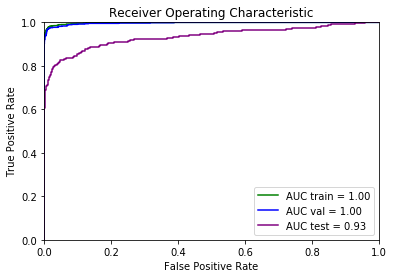

auc test : 0.9337677598547165
1396
407


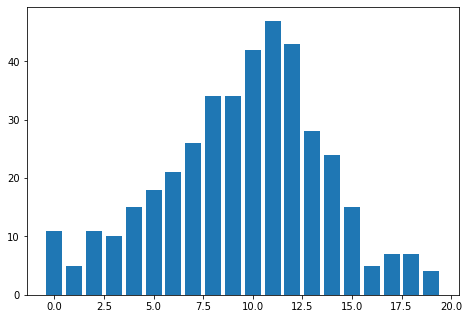

In [9]:
all_col = kiddi.get_all_columns()
param = dict()
param['tree_num'] = 100
param['depth'] = 10
model = kiddi.train_model('random_forest', param, all_col)

depth is : 10, tree_num : 100
train auc : 0.9964583242196132
validation auc : 0.9952078468712546
Test auc : 0.9463210797892294


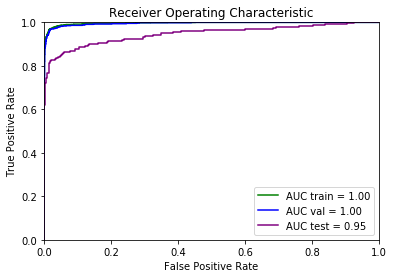

auc test : 0.9463210797892294
1396
407


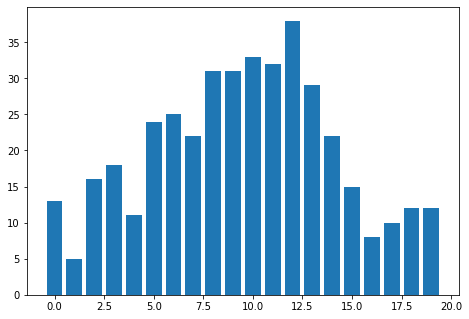

In [10]:
ft_imp = model.feature_importances_
new_col = []
for c, f in zip(ft_imp, all_col):
    new_col.append((c, f))
new_col.sort(reverse=True)
top_100_col = np.array(new_col[:200])[:, 1]
param = dict()
param['tree_num'] = 100
param['depth'] = 10
model_top100_list = kiddi.train_model('random_forest', param, top_100_col)

In [11]:
ft_imp = model_top100_list.feature_importances_
new_col = []
for c, f in zip(ft_imp, top_100_col):
    new_col.append((c, f))
new_col.sort(reverse=True)
new_col = np.array(new_col)
ft_tmp = pd.DataFrame(new_col, columns=['value', 'feature'])
ft_tmp = ft_tmp[['feature', 'value']]
ft_tmp

,feature,value
0,qLymphVal_min_12mth,0.0311450437294948
1,qNeutrophilsVal_max_9mth,0.012413411800266077
2,PDVintage,0.012350148353593618
3,qLymphVal_min_9mth,0.011600192871634114
4,zscore_sex_BactInfec_sum_12mth,0.010059192983079446
...,...,...
195,zscore_sex_qExch2CAPDDwellTime_sum_12mth,0.0023279882202687685
196,zscore_sex_qHDLCholVal_sum_9mth,0.0022898009767863842
197,BactInfec_avg_9mth,0.0015643809199445977
198,BactInfec_avg_6mth,0.001457167507734221


In [12]:
kiddi.get_final_score()

,idd,ft_data_dt,score
0,8020013,2017-05-31,0.223108
1,8020015,2017-05-31,0.145648
2,8020019,2017-05-31,0.096430
3,8020020,2017-05-31,0.106115
4,8020021,2017-05-31,0.743197
...,...,...,...
1391,8001511,2017-06-30,0.104254
1392,8008006,2017-06-30,0.163377
1393,8001513,2017-06-30,0.094139
1394,8001514,2017-06-30,0.047905
